In [2]:
!wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv

--2024-09-08 20:37:00--  https://lazyprogrammer.me/course_files/AirlineTweets.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 2606:4700:3031::6815:17d2, 2606:4700:3030::ac43:d5a6, 104.21.23.210, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|2606:4700:3031::6815:17d2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3421431 (3,3M) [text/csv]
Saving to: 'AirlineTweets.csv'

     0K .......... .......... .......... .......... ..........  1% 27,5M 0s
    50K .......... .......... .......... .......... ..........  2% 11,4M 0s
   100K .......... .......... .......... .......... ..........  4%  348K 3s
   150K .......... .......... .......... .......... ..........  5% 10,9M 2s
   200K .......... .......... .......... .......... ..........  7% 10,4M 2s
   250K .......... .......... .......... .......... ..........  8% 13,6M 2s
   300K .......... .......... .......... .......... .......... 10%  354K 3s
   350K .......... .......... .......... .......... 

In [9]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight


from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.models import Model


In [10]:
threshold = 0.5 # confidence in sentiment threshold

def process_string(s):
    # Split the string on spaces
    words = s.split()

    # Remove first element
    words.pop(0)

    # Rejoin the list into a string
    return ' '.join(words)


df = pd.read_csv('AirlineTweets.csv',delimiter=",")
df = df[df['airline_sentiment_confidence']>threshold]
df = df[['airline_sentiment','text']]

# Apply the function to each row in the DataFrame
df['text'] = df['text'].apply(process_string)

sentiment = df["airline_sentiment"]
text = df["text"]



## Convert classes to numbers
target_map = {"positive":1,"negative":0,"neutral":2}
df['target'] = df['airline_sentiment'].map(target_map)


# Display the first few rows of the DataFrame
print(df.head())
print(f"Number of samples: {len(df)}")



  airline_sentiment                                               text  target
0           neutral                               What @dhepburn said.       2
2           neutral  I didn't today... Must mean I need to take ano...       2
3          negative  it's really aggressive to blast obnoxious "ent...       0
4          negative           and it's a really big bad thing about it       0
5          negative  seriously would pay $30 a flight for seats tha...       0
Number of samples: 14404


<Axes: >

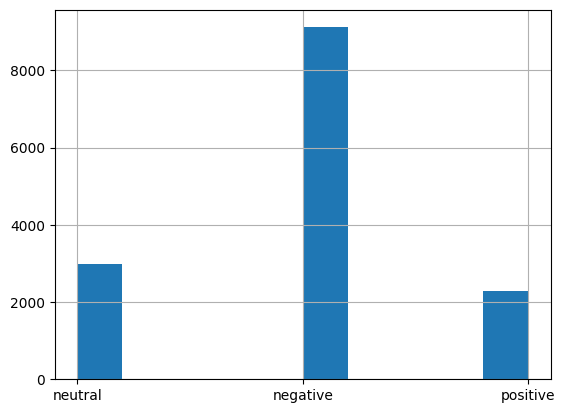

In [11]:
# Check for class imbalance (HUUGE)

df['airline_sentiment'].hist()

In [19]:
# df = pd.read_csv('AirlineTweets.csv',delimiter=",")

df_train,df_test = train_test_split(df, test_size=0.3, random_state=42)

tfidf_vectorizer = TfidfVectorizer(lowercase=True,stop_words='english')

Xtrain = tfidf_vectorizer.fit_transform(df_train['text'])
Xtest = tfidf_vectorizer.transform(df_test['text'])

Ytrain = df_train['target']
Ytest = df_test['target']

# compute class weight to counteract class imbalannce
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(Ytrain), y=Ytrain)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}


# Number of classes
K = df['target'].value_counts().value_counts().sum()
print(f"Num of classes: {K}")

# input dimensions
D = Xtrain.shape[1]
print(f"Iput D {D}")

# tensorflow needs array in non sparse form
Xtrain = Xtrain.toarray()
Xtest = Xtest.toarray()


# These seem to be helping, not sure why
# Convert to NumPy arrays if they are not already
Ytrain = Ytrain.to_numpy() if hasattr(Ytrain, "to_numpy") else Ytrain
Ytest = Ytest.to_numpy() if hasattr(Ytest, "to_numpy") else Ytest


# Build model
i = Input(shape=(D,))
x = Dense(500,activation='relu')(i)
x = Dense(K)(x) # softmax in loss

model = Model(i,x)
model.summary()

Num of classes: 3
Iput D 11841


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 11841)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 500)            │     5,921,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │         1,503 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,922,503 (22.59 MB)

 Trainable params: 5,922,503 (22.59 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/7
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.6717 - loss: 1.0001 - val_accuracy: 0.7580 - val_loss: 0.6266
Epoch 2/7
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.8501 - loss: 0.4773 - val_accuracy: 0.7601 - val_loss: 0.5902
Epoch 3/7
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.9155 - loss: 0.2619 - val_accuracy: 0.7621 - val_loss: 0.6048
Epoch 4/7
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9484 - loss: 0.1676 - val_accuracy: 0.7596 - val_loss: 0.6648
Epoch 5/7
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.9644 - loss: 0.1226 - val_accuracy: 0.7547 - val_loss: 0.7279
Epoch 6/7
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.9701 - loss: 0.1013 - val_accuracy: 0.7515 - val_loss: 0.7870
Epoch 7/7
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.9747 - loss: 0.0859 - val_accuracy: 0.7510 - val_loss: 0.8383


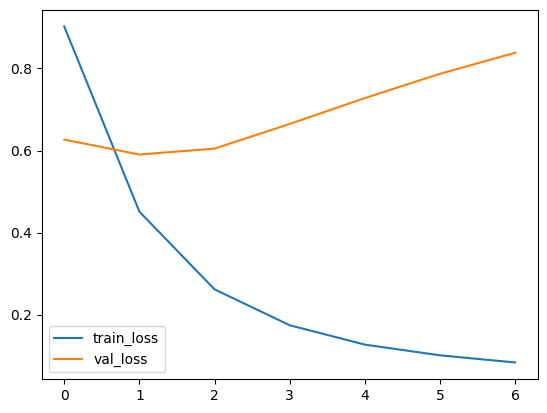

In [20]:
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
    )

r = model.fit(
    Xtrain,Ytrain,
    validation_data=(Xtest,Ytest),
    epochs = 7,
    class_weight = class_weight_dict,
    batch_size = 128


)

# plot loss/iteration

plt.plot(r.history['loss'],label = 'train_loss')
plt.plot(r.history['val_loss'],label = 'val_loss')
plt.legend()

In [21]:
#Calculate AUC Score
P_train = tf.nn.softmax(model.predict(Xtrain))
P_test = tf.nn.softmax(model.predict(Xtest))


print("Train AUC:",roc_auc_score(Ytrain,P_train,multi_class='ovo'))
print("Test AUC:",roc_auc_score(Ytest,P_test,multi_class='ovo'))


316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Train AUC: 0.998858682535474
Test AUC: 0.8536246301787701


In [23]:
# Sample custom text for prediction
custom_text = ["it was stellar", "it was awesome","worst ever","best ever service "]

# Transform the custom text using the same vectorizer
custom_text_vectorized = tfidf_vectorizer.transform(custom_text)
custom_text_vectorized = custom_text_vectorized.toarray()

# Make the prediction
predictions = tf.nn.softmax(model.predict(custom_text_vectorized))


# Get the class with the highest probability
predicted_classes = np.argmax(predictions, axis=1)

# Map the predicted classes to text labels
class_labels = ['negative', 'positive', 'neutral']
predicted_labels = [class_labels[i] for i in predicted_classes]



# Display the predictions
for text, prediction in zip(custom_text, predicted_labels):
    print(f"Text: {text}\nPrediction: {prediction}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Text: it was stellar
Prediction: positive

Text: it was awesome
Prediction: positive

Text: worst ever
Prediction: negative

Text: best ever service 
Prediction: positive

